## Создание регрессора одной переменной 

Вам представлены данные о доходах сотрудников участка горячего проката за год, в том числе данные, описывающие специфику рабочих мест.
Доход состоит из оклада, премии, доплат и индивидуальных надбавок. Данных об их размерах не приводится, так как именно их Вам предстоит восстановить.
Задание 
Выявите формулу дохода в целом и его составных частей
Проверьте, что данная формула объясняет доход с точностью до рубля
Выявите зависимости между составными частями дохода

Итоговую формулу напишите, пожалуйста, в теле письма или в Word. Все расчеты и объяснения приложите отдельным файлом.



In [3]:
import pickle
import numpy as np
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
import scipy.stats as ss

In [2]:
import seaborn as sns

In [4]:
file = pd.read_excel("test-case/Задание 5.0 2 версия.xlsx")
file.head()

,FIO,Месяц,Профессия,Разряд,Оборудование,Вредность (балл.),Объем производства,Доход
0,Абрамов Е. Д.,2009-01-01,Уборщик,3,Пилигримовые станы,18,580,16638.000000
1,Абрамов Е. Д.,2009-02-01,Уборщик,3,Пилигримовые станы,18,790,16638.000000
2,Абрамов Е. Д.,2009-03-01,Уборщик,3,Пилигримовые станы,18,820,16638.000000
3,Абрамов Е. Д.,2009-04-01,Уборщик,3,Пилигримовые станы,18,1200,19396.411765
4,Абрамов Е. Д.,2009-05-01,Уборщик,3,Пилигримовые станы,18,1250,19790.470588


In [33]:
file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   FIO                 2400 non-null   object        
 1   Месяц               2400 non-null   datetime64[ns]
 2   Профессия           2400 non-null   object        
 3   Разряд              2400 non-null   int64         
 4   Оборудование        2400 non-null   object        
 5   Вредность (балл.)   2400 non-null   int64         
 6   Объем производства  2400 non-null   int64         
 7   Доход               2400 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 150.1+ KB


**continious features (непрерывные признаки)** - доход, вредность, обеъе производства, разряд, месяц (хотя некоторые из этих признаков изменяются дискретно, а не непрерывно, их можно сравнить друг с другом)

**categorical features (категориальные признаки)** - оборудование, профессия, фио. Фиксированный набор значений, который не поддаются абсолютному сравнению (нельзя сравнить тип профессии друг с другом)


In [25]:
cat_features = ['Оборудование', 'Профессия', 'FIO']
drop_cat = file.copy(deep=True)
drop_cat.drop(labels=cat_features, axis=1, inplace=True) 
# записываем в новую переменную новый датафрейм только с непрерывными признаками. 
# axis=1 (удаление по колонкам), inplace=True (не меняем исходную таблицу)
drop_cat

,Месяц,Разряд,Вредность (балл.),Объем производства,Доход
0,2009-01-01,3,18,580,16638.000000
1,2009-02-01,3,18,790,16638.000000
2,2009-03-01,3,18,820,16638.000000
3,2009-04-01,3,18,1200,19396.411765
4,2009-05-01,3,18,1250,19790.470588
...,...,...,...,...,...
2395,2009-08-01,4,18,1180,21800.170588
2396,2009-09-01,4,18,1080,20885.876471
2397,2009-10-01,4,18,780,18783.000000
2398,2009-11-01,4,18,1020,20337.300000


In [30]:
file.groupby('Разряд')['Доход']

In [31]:
drop_cat.describe()

,Разряд,Вредность (балл.),Объем производства,Доход
count,2400.000000,2400.000000,2400.000000,2400.000000
mean,4.900000,15.785000,988.333333,21665.570570
std,1.371417,6.567857,230.982220,4686.885527
min,3.000000,0.000000,580.000000,12180.000000
25%,4.000000,14.750000,805.000000,18076.500000
50%,5.000000,18.000000,985.000000,21057.300000
75%,6.000000,19.000000,1185.000000,25105.764706
max,7.000000,22.000000,1400.000000,36076.764706


70% строк из столбцов с доходами будут тренировочными данными, 30% строк тестовыми данными

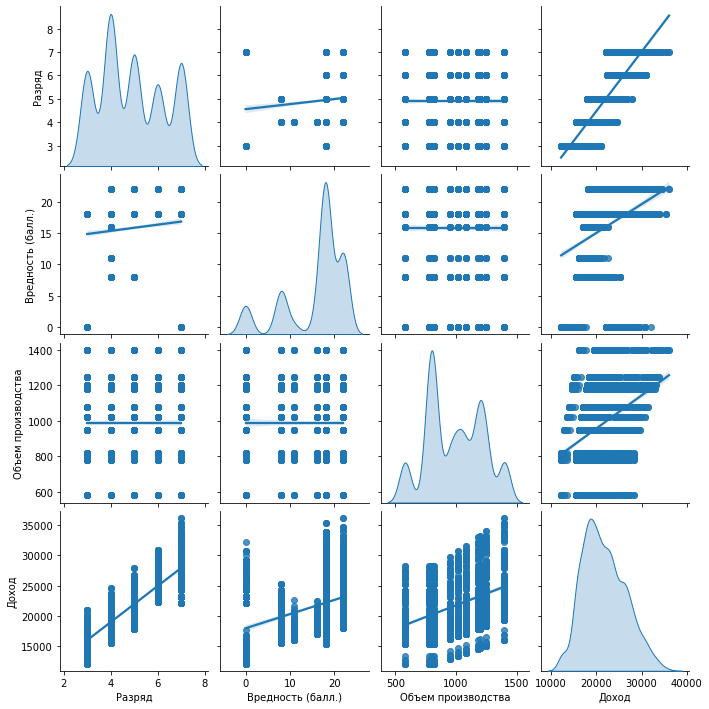

In [5]:
sns.pairplot(file, diag_kind="kde", kind="reg")

<AxesSubplot:xlabel='Объем производства', ylabel='Count'>

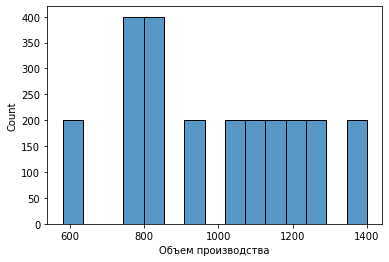

In [9]:
sns.histplot(file['Объем производства'], kde=False)

<AxesSubplot:xlabel='Объем производства', ylabel='Count'>

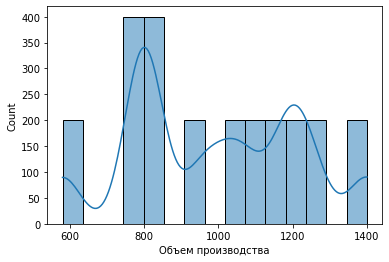

In [10]:
sns.histplot(file['Объем производства'], kde=True)

Чтобы предсказать формулу, можно воспользоваться **символьной регрессией**

In [8]:
from gplearn.genetic import SymbolicRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils.random import check_random_state
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import graphviz

К примеру, попробуем угадать эту формулу: ${\displaystyle y = x_1 + x_2^2}$

In [41]:
x1 = np.arange(1, 10, .3)
x2 = np.arange(2, 14, .4)
y = x1+x2**2
table_val = pd.DataFrame({'x₁': x1, 'x₂': x2, 'y = x₁+x₂²': y})
table_val

,x₁,x₂,y = x₁+x₂²
0,1.0,2.0,5.00
1,1.3,2.4,7.06
2,1.6,2.8,9.44
3,1.9,3.2,12.14
4,2.2,3.6,15.16
5,2.5,4.0,18.50
6,2.8,4.4,22.16
7,3.1,4.8,26.14
8,3.4,5.2,30.44
9,3.7,5.6,35.06


Чтобы построить трехмерный график из DataFrame, нужно не прокидывать
мы не можем прокидывать его целиком в `plot_surface(table_val)` и прокидывать по осям `plot_surface(table_val["x₁"], table_val["x₂"], table_val["y = x₁+x₂²"])`

In [46]:
fig = plt.figure(figsize=(10, 40))
#fig.rcParam[7, 5] # делаем график чуть больше (по умолчанию )

# для трехмерного графика сначала добавляются оси
#axes = fig.add_subplot(projection="3d") 

table_val2 = pd.plotting.table(axes, table_val)
fig.table(table_val2)
#axes.plot_surface(table_val)

AttributeError: 'Figure' object has no attribute 'table'

<Figure size 720x2880 with 0 Axes>

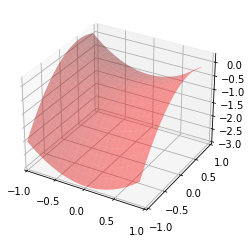

In [22]:
x0 = np.arange(-1, 1, .1)
x1 = np.arange(-1, 1, .1)
x0, x1 = np.meshgrid(x0, x1)
y_truth = x0**2 - x1**2 + x1 - 1 #true function

ax = plt.figure().gca(projection='3d')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_xticks(np.arange(-1, 1.01, .5))
ax.set_yticks(np.arange(-1, 1.01, .5))
surf = ax.plot_surface(x0, x1, y_truth, rstride=1, cstride=1, color='red', alpha=0.4)
plt.show()

In [36]:
train_data_Y, test_data_Y = file["Доход"][:1679], file["Доход"][1679:2400]
train_data_X1 = file["Объем производства"][:1679]
train_data_X2 = file["Вредность (балл.)"][:1679]
train_data_X3 = file["Разряд"][:1679]
train_data_X3

0       3
1       3
2       3
3       3
4       3
       ..
1674    5
1675    5
1676    5
1677    5
1678    5
Name: Разряд, Length: 1679, dtype: int64

In [67]:
train_data_YX1 = file[['Доход', 'Разряд']]
print(train_data_YX1)

             Доход  Разряд
0     16638.000000       3
1     16638.000000       3
2     16638.000000       3
3     19396.411765       3
4     19790.470588       3
...            ...     ...
2395  21800.170588       4
2396  20885.876471       4
2397  18783.000000       4
2398  20337.300000       4
2399  18783.000000       4

[2400 rows x 2 columns]


D:\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

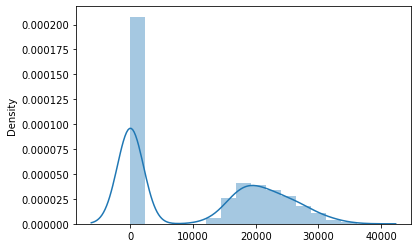

In [61]:
sns.distplot(train_data_YX1)

D:\Anaconda\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 75.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
D:\Anaconda\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 99.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:>

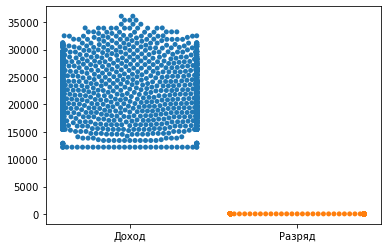

In [58]:
sns.swarmplot(data=train_data_YX1)

D:\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Вредность (балл.)', ylabel='Density'>

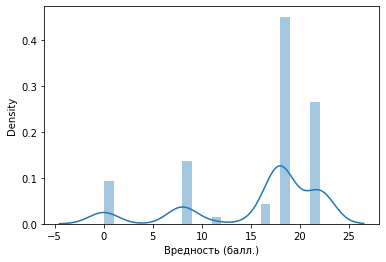

In [44]:
sns.distplot(train_data_X2)

TypeError: cannot perform reduce with flexible type

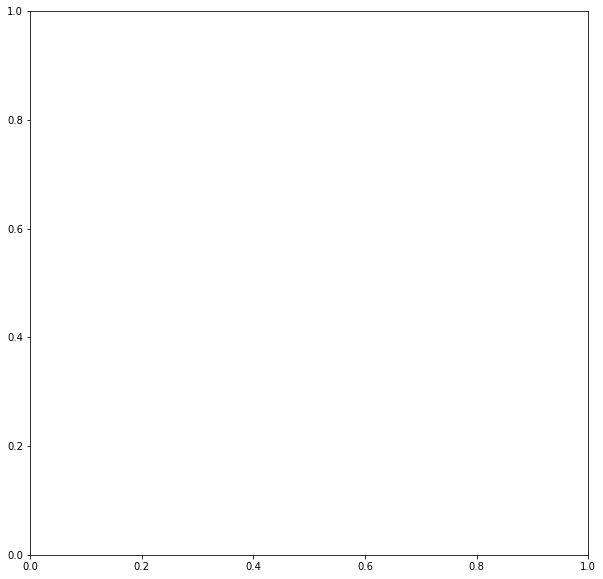

In [40]:
plt.boxplot()

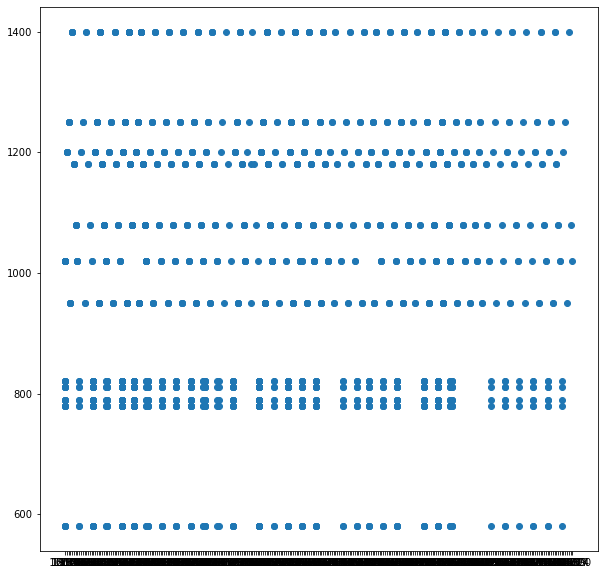

In [37]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.scatter(train_data_Y, train_data_X)

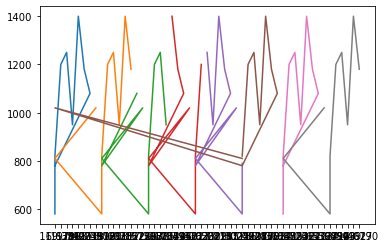

In [20]:
#plt.scatter(train_data_X, train_data_Y)
i = 0
while i<=70:
    plt.plot(train_data_Y[i:i+10], train_data_X[i:i+10])
    i+=10

Линейная регрессия - зависимость дохода от объема производства

In [11]:
regression = linear_model.LinearRegression()
regression.fit(train_data_X, train_data_Y)

ValueError: Expected 2D array, got 1D array instead:
array=[ 580  790  820 ... 1080  780 1020].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.